### Pre-processing and combining dfs ###

In [1]:
import pandas as pd
import numpy as np
import os
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon, box, LineString

# For a single participant (with plots)

In [2]:
# Get participant number input
participant_number = input("Enter participant number: ")

# Define the base path
base_path = "/Users/alina/Downloads/Thesis/raw/"

# Build the folder path for the participant
folder_path = os.path.join(base_path, f"Participant {participant_number}")

# Get recording number input
recording_number = input("Enter recording number: ")

# Build the recording folder path
recording_path = os.path.join(folder_path, f"P{participant_number}_{recording_number}")

# Read the CSV files with dynamic paths
events_file = os.path.join(recording_path, f"events.csv")
face_detections_file =  os.path.join(recording_path, "face_detections.csv")
fixations_file = os.path.join(recording_path, "fixations.csv")
face_file = os.path.join(recording_path, "fixations_on_face.csv")

# Load the data
events_df = pd.read_csv(events_file)
face_detections_df = pd.read_csv(face_detections_file)
fixations_df = pd.read_csv(fixations_file)
face_df = pd.read_csv(face_file)

## function_1 for leaving only experiment-relevant data

def filter_by_intervals(df, intervals, timestamp_col='timestamp [ns]'):
    """
    Filters a DataFrame to include only rows where the timestamp falls within any given intervals.

    Parameters:
        df: The DataFrame to filter.
        intervals (list of tuple): List of (start_time, end_time) pairs.
        timestamp_col (str): Name of the timestamp column.

    Returns:
        pd.DataFrame: Filtered DataFrame with rows in any of the intervals.
    """
    filter = pd.Series(False, index=df.index)  # start with all False

    for start, end in intervals:
        filter |= (df[timestamp_col] >= start) & (df[timestamp_col] <= end)

    return df[filter]

## to filter each file by leaving only experiment timestamps

events_df = events_df.sort_values("timestamp [ns]")

# Filter for events where name == 'A'
A_events = events_df[events_df["name"] == "A"]
B_events = events_df[events_df["name"] == "B"]
C_events = events_df[events_df["name"] == "C"]
D_events = events_df[events_df["name"] == "D"]

# Get the highest (except D) and lowest (except A) timestamp from that filtered DataFrame
max_timestamp_A = A_events["timestamp [ns]"].max()
min_timestamp_B = B_events["timestamp [ns]"].min()

max_timestamp_B = B_events["timestamp [ns]"].max()
min_timestamp_C = C_events["timestamp [ns]"].min()

max_timestamp_C = C_events["timestamp [ns]"].max()
min_timestamp_D = D_events["timestamp [ns]"].min()

# intervals to use for filter_by_intervals function
intervals = [
    (max_timestamp_A, min_timestamp_B),
    (max_timestamp_B, min_timestamp_C),
    (max_timestamp_C, min_timestamp_D)
]

In [3]:
## to assign aois based on voronoi method for each row

def which_aoi(fix_x, fix_y, aoi_centers):
    
    """ Assigns the fixation to the nearest AOI center using Euclidean distance. """

    min_dist = float('inf')
    closest_aoi = None

    for aoi_id, (aoi_x, aoi_y) in aoi_centers.items():
        dist = np.sqrt((fix_x - aoi_x)**2 + (fix_y - aoi_y)**2)
        if dist < min_dist:
            min_dist = dist
            closest_aoi = aoi_id

    return closest_aoi

In [4]:
face_detections_df = filter_by_intervals(face_detections_df, intervals, timestamp_col='timestamp [ns]')
fixations_df = filter_by_intervals(fixations_df, intervals, timestamp_col='start timestamp [ns]')
face_df = filter_by_intervals(face_df, intervals, timestamp_col='start timestamp [ns]')

#
face_with_coordinates_df = pd.merge(
    fixations_df,
    face_df,
    on="start timestamp [ns]",
    how="inner"  # or "left" if you want to keep all fixations and NaNs for unmatched
)

# leave only fixations on face
face_with_coordinates_df = face_with_coordinates_df[face_with_coordinates_df['fixation on face'] == True]

#face_with_coordinates_df.head()
#print(len(face_with_coordinates_df))


In [5]:
matched_rows = []
unmatched_fixations = 0

# Make sure timestamps are integers
face_detections_df['timestamp [ns]'] = face_detections_df['timestamp [ns]'].astype(int)

# Get sorted unique timestamps
unique_timestamps = face_detections_df['timestamp [ns]'].sort_values().unique()

for i, fixation_row in face_with_coordinates_df.iterrows():
    ts_start = fixation_row['start timestamp [ns]']
    ts_end = fixation_row['end timestamp [ns]_x']
    fx = fixation_row['fixation x [px]']
    fy = fixation_row['fixation y [px]']

    timestamps_in_interval = unique_timestamps[(unique_timestamps >= ts_start) & (unique_timestamps <= ts_end)]
    
    found = False
    for ts in timestamps_in_interval:
        detections_at_ts = face_detections_df[face_detections_df['timestamp [ns]'] == ts]
        
        for _, det_row in detections_at_ts.iterrows():
            x1 = det_row['p1 x [px]']
            y1 = det_row['p1 y [px]']
            x2 = det_row['p2 x [px]']
            y2 = det_row['p2 y [px]']

            if x1 <= fx <= x2 and y1 <= fy <= y2:
                combined = {**fixation_row.to_dict(), **det_row.to_dict()}
                matched_rows.append(combined)
                found = True
                break  # Only first match at this timestamp

        if found:
            break  # Stop checking further timestamps once matched

    if not found:
        unmatched_fixations += 1

print(f"Total fixations: {len(face_with_coordinates_df)}")
print(f"Matched fixations: {len(matched_rows)}")
print(f"Unmatched fixations: {unmatched_fixations}")

matched_df = pd.DataFrame(matched_rows)


Total fixations: 226
Matched fixations: 208
Unmatched fixations: 18


In [6]:
def mouth_centre(m_left_x, m_left_y, m_right_x, m_right_y):
    # Calculate the center of the mouth by averaging the x and y coordinates
    mouth_x = (m_left_x + m_right_x) / 2
    mouth_y = (m_left_y + m_right_y) / 2
    return mouth_x, mouth_y

def which_aoi(fx, fy, aoi_centers):
    """Assign AOI based on closest landmark."""
    distances = {}
    for key, (x, y) in aoi_centers.items():
        distances[key] = ((fx - x)**2 + (fy - y)**2)**0.5
    return min(distances, key=distances.get)

"""def is_off_center(left_eye, right_eye, nose, threshold=1):
    #Check if nose is significantly off-center relative to eyes.
    midpoint = ((left_eye[0] + right_eye[0])/2, (left_eye[1] + right_eye[1])/2)
    iod = ((left_eye[0] - right_eye[0])**2 + (left_eye[1] - right_eye[1])**2)**0.5
    distance = ((nose[0] - midpoint[0])**2 + (nose[1] - midpoint[1])**2)**0.5
    return distance > threshold * iod"""

def is_nose_outside_eyes(left_eye, right_eye, nose):
    return nose[0] < min(left_eye[0], right_eye[0]) or nose[0] > max(left_eye[0], right_eye[0])


# Initialize lists for new columns
assigned_aois = []
partial_faces = []

for _, row in matched_df.iterrows():

    mouth_x, mouth_y = mouth_centre(
                row['mouth left x [px]'], row['mouth left y [px]'],
                row['mouth right x [px]'], row['mouth right y [px]']
            )
    # AOI assignment
    aoi_centers = {
                'left_eye': (row['eye left x [px]'], row['eye left y [px]']),
                'right_eye': (row['eye right x [px]'], row['eye right y [px]']),
                'nose': (row['nose x [px]'], row['nose y [px]']),
                'mouth': (mouth_x, mouth_y)
            }
    
    assigned_aoi = which_aoi(row['fixation x [px]'], row['fixation y [px]'], aoi_centers)
    assigned_aois.append(assigned_aoi)

    # Partial/full face classification
    left_eye = (row['eye left x [px]'], row['eye left y [px]'])
    right_eye = (row['eye right x [px]'], row['eye right y [px]'])
    nose = (row['nose x [px]'], row['nose y [px]'])
    partial = is_nose_outside_eyes(left_eye, right_eye, nose)
    partial_faces.append(partial)

matched_df['assigned_aoi'] = assigned_aois
matched_df['partial_face'] = partial_faces

# Split into partial and full faces
partial_faces_df = matched_df[matched_df['partial_face']]
full_faces_df = matched_df[~matched_df['partial_face']]

print("Partial faces:", len(partial_faces_df))
print("Full faces:", len(full_faces_df))


Partial faces: 19
Full faces: 189


In [7]:
partial_faces_df

,section id_x,recording id_x,fixation id_x,start timestamp [ns],end timestamp [ns]_x,duration [ms],fixation x [px],fixation y [px],azimuth [deg],elevation [deg],...,eye right x [px],eye right y [px],nose x [px],nose y [px],mouth left x [px],mouth left y [px],mouth right x [px],mouth right y [px],assigned_aoi,partial_face
87,2ec448bc-1c60-4549-9c03-6b327b7f7e37,8ef60243-2690-4dac-9837-d7b0a844badb,1577,1742393202462575145,1742393202837950145,375,375.941,474.547,-28.687262,8.117030,...,380.481,470.087,384.314,475.296,380.515,482.211,381.213,481.852,left_eye,True
89,2ec448bc-1c60-4549-9c03-6b327b7f7e37,8ef60243-2690-4dac-9837-d7b0a844badb,1751,1742393263293826145,1742393263438951145,145,1101.641,421.460,18.209885,11.684850,...,1100.957,427.063,1102.995,433.550,1095.537,438.282,1097.120,438.699,right_eye,True
94,2ec448bc-1c60-4549-9c03-6b327b7f7e37,8ef60243-2690-4dac-9837-d7b0a844badb,2364,1742393457309417145,1742393457469526145,160,578.212,410.186,-15.821710,12.448039,...,573.580,412.932,568.466,417.787,570.186,422.201,573.104,422.182,right_eye,True
109,2ec448bc-1c60-4549-9c03-6b327b7f7e37,8ef60243-2690-4dac-9837-d7b0a844badb,2674,1742393564063731145,1742393564353981145,290,833.905,169.843,0.877865,27.959745,...,848.623,106.430,782.881,193.785,832.542,247.968,876.036,230.899,nose,True
110,2ec448bc-1c60-4549-9c03-6b327b7f7e37,8ef60243-2690-4dac-9837-d7b0a844badb,2675,1742393564394106145,1742393564609232145,215,827.680,293.525,0.425579,20.079350,...,802.664,181.468,757.382,260.655,817.331,304.365,836.349,296.062,mouth,True
111,2ec448bc-1c60-4549-9c03-6b327b7f7e37,8ef60243-2690-4dac-9837-d7b0a844badb,2679,1742393565324857145,1742393565550107145,225,779.257,199.922,-2.890481,26.031551,...,769.454,145.685,723.750,222.775,782.610,265.875,801.058,256.779,left_eye,True
112,2ec448bc-1c60-4549-9c03-6b327b7f7e37,8ef60243-2690-4dac-9837-d7b0a844badb,2680,1742393565580107145,1742393565860357145,280,728.651,239.703,-6.283547,23.459511,...,719.012,154.693,675.580,233.781,739.687,273.613,755.267,257.620,mouth,True
132,2ec448bc-1c60-4549-9c03-6b327b7f7e37,8ef60243-2690-4dac-9837-d7b0a844badb,2831,1742393619754798145,1742393619925048145,170,832.711,168.355,0.795299,28.054862,...,909.736,125.778,914.139,191.055,831.033,246.120,885.035,258.387,left_eye,True
133,2ec448bc-1c60-4549-9c03-6b327b7f7e37,8ef60243-2690-4dac-9837-d7b0a844badb,2832,1742393619960048145,1742393620415423145,455,890.206,137.015,4.861823,30.024102,...,920.593,137.845,933.838,203.844,849.147,256.406,899.100,263.171,right_eye,True
135,2ec448bc-1c60-4549-9c03-6b327b7f7e37,8ef60243-2690-4dac-9837-d7b0a844badb,2838,1742393622737674145,1742393623203049145,465,877.672,252.957,3.808349,22.647611,...,902.700,187.500,929.345,255.651,846.220,307.099,884.524,312.472,nose,True


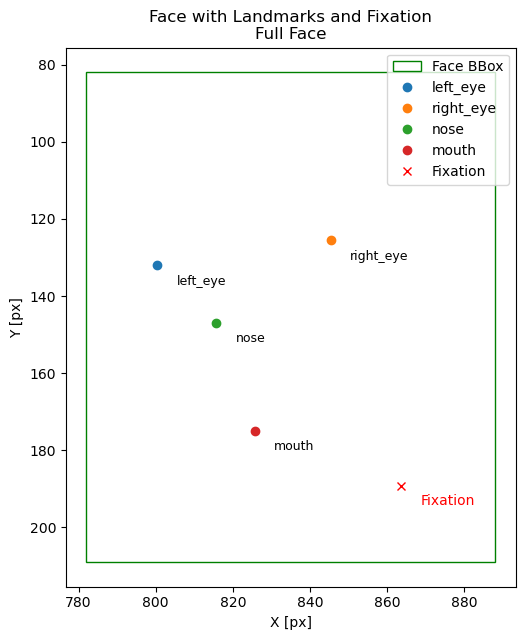

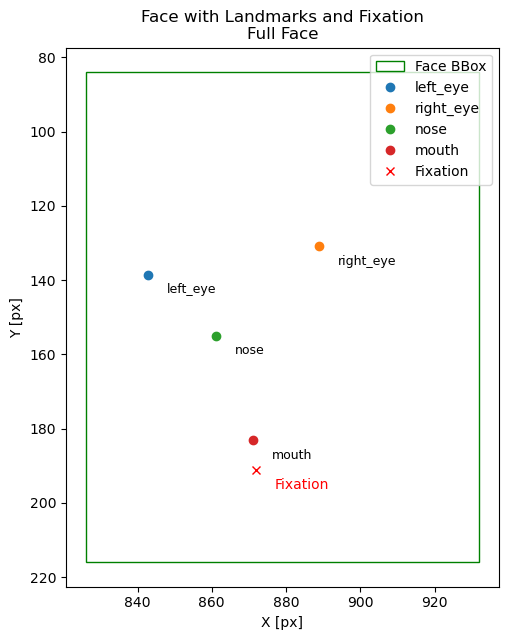

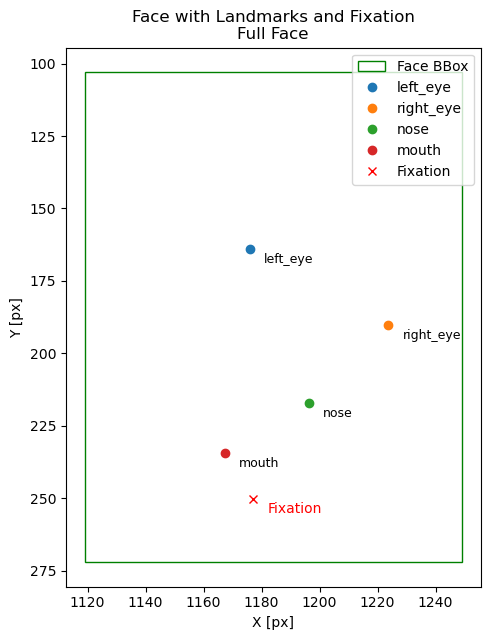

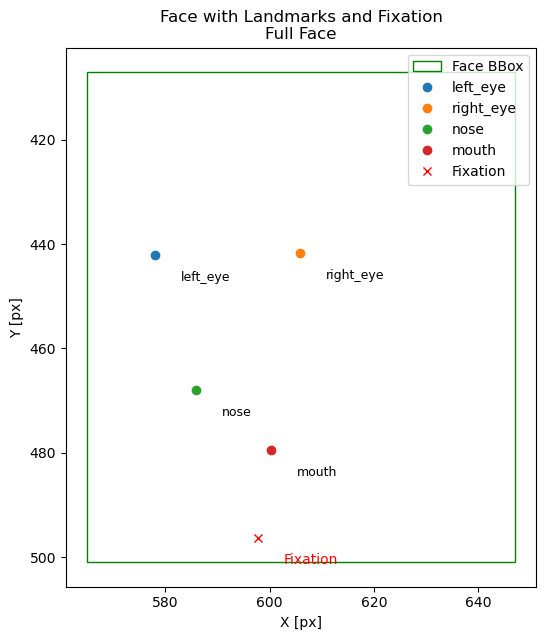

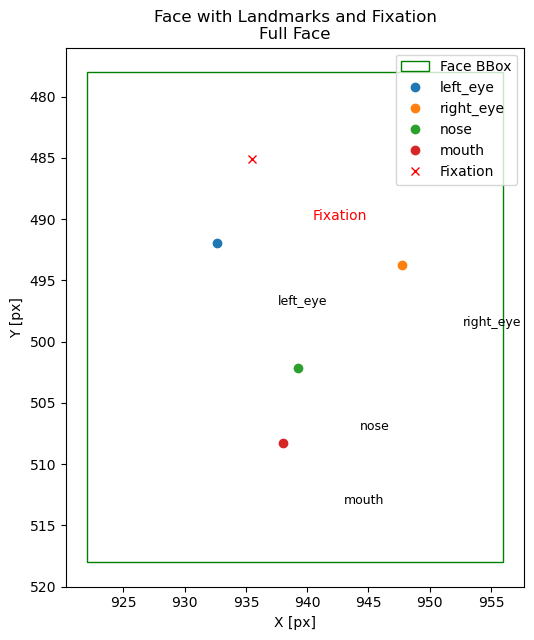

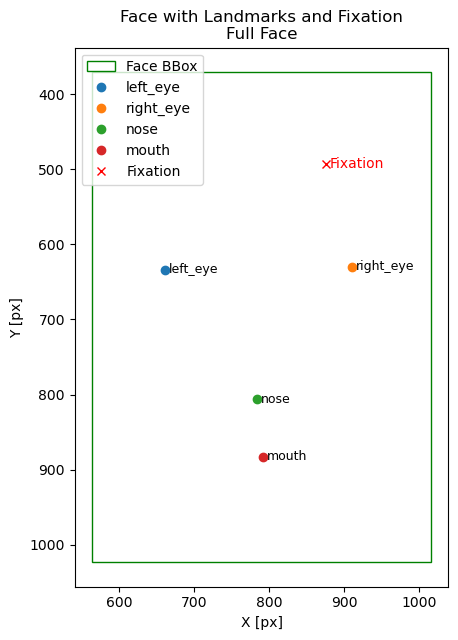

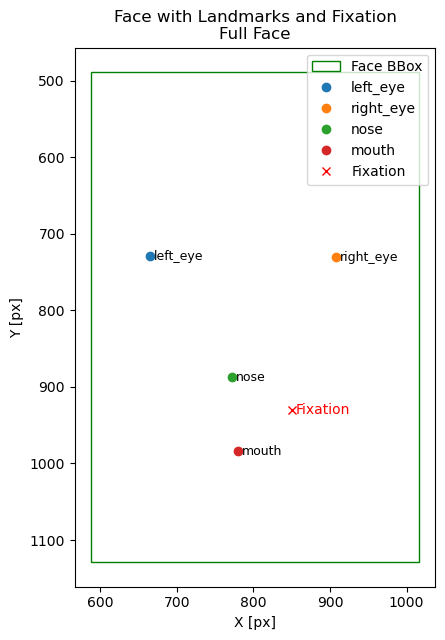

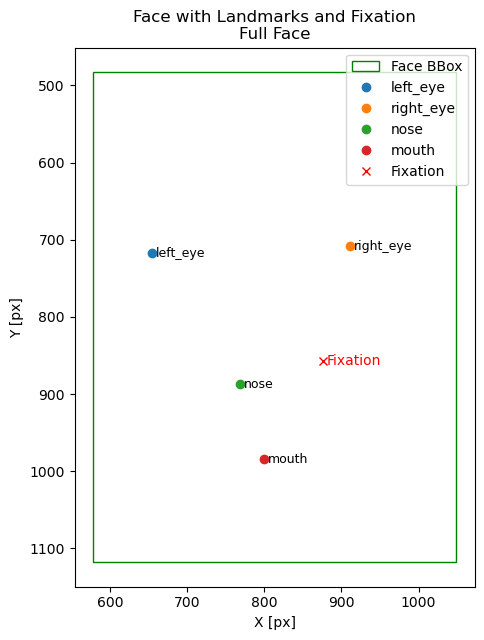

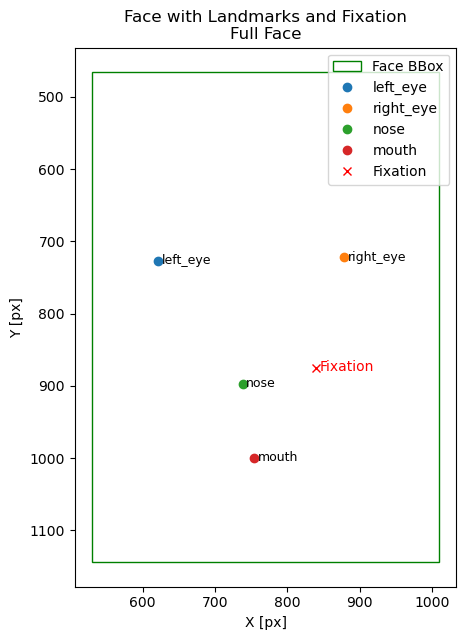

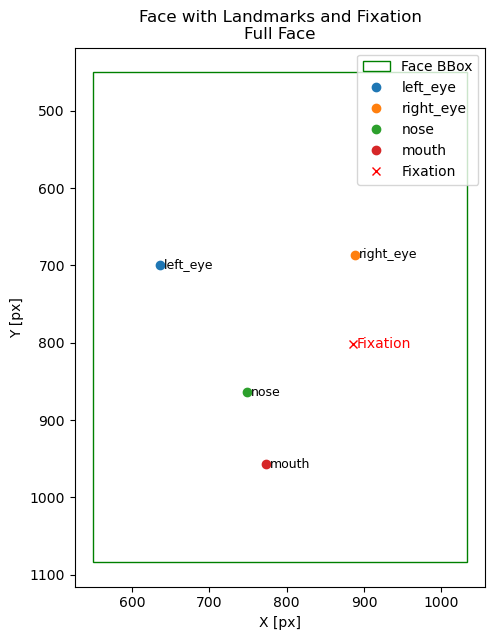

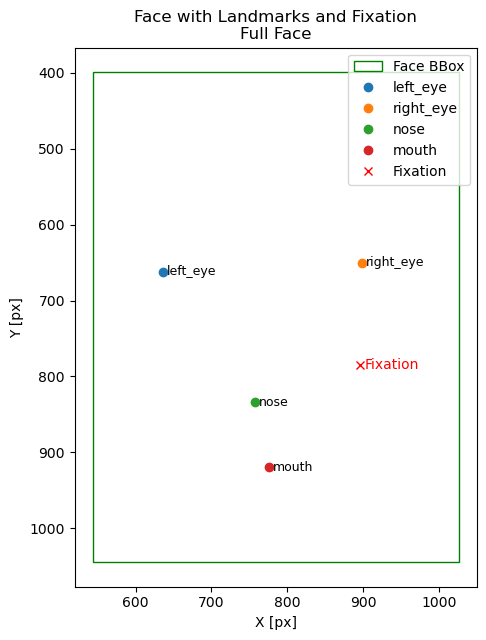

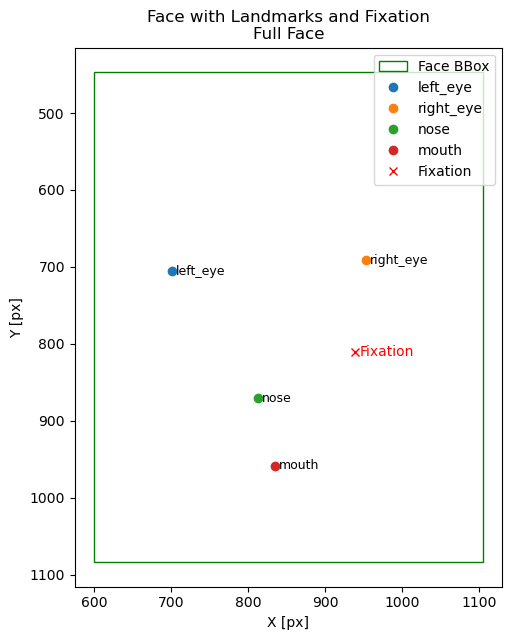

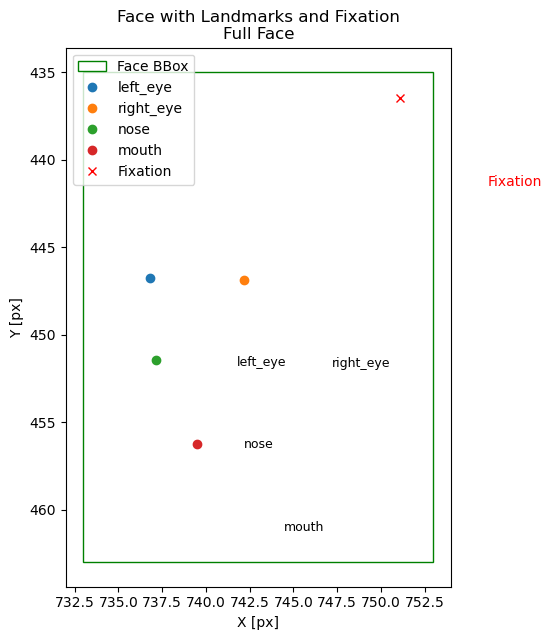

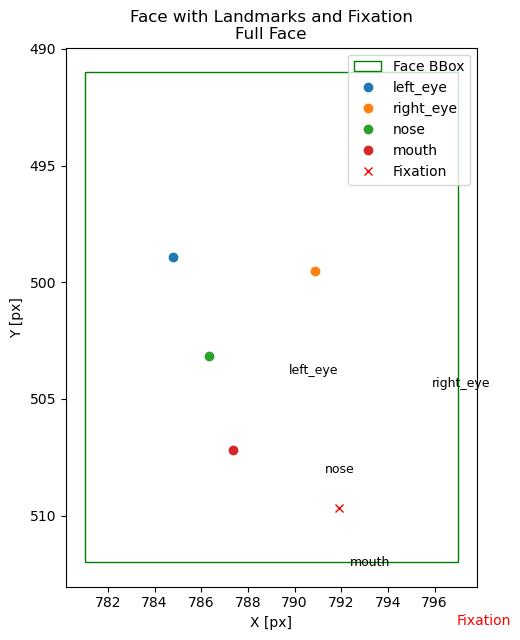

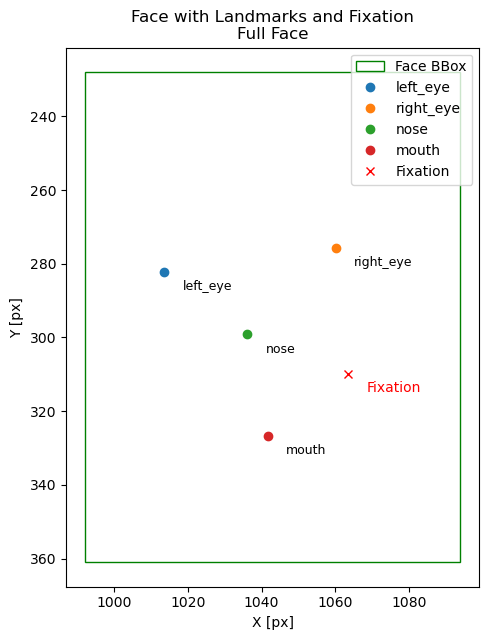

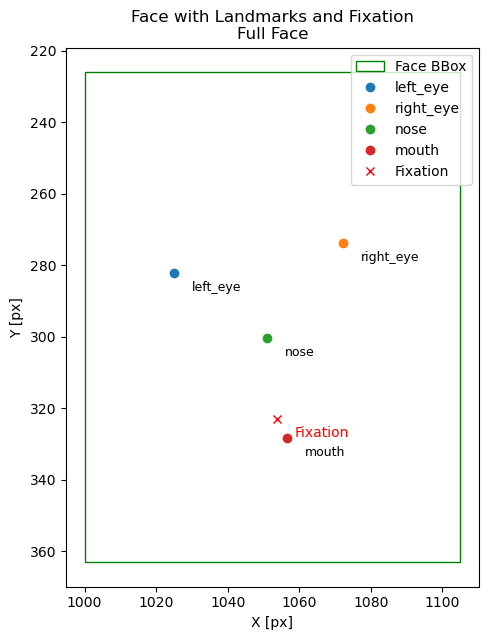

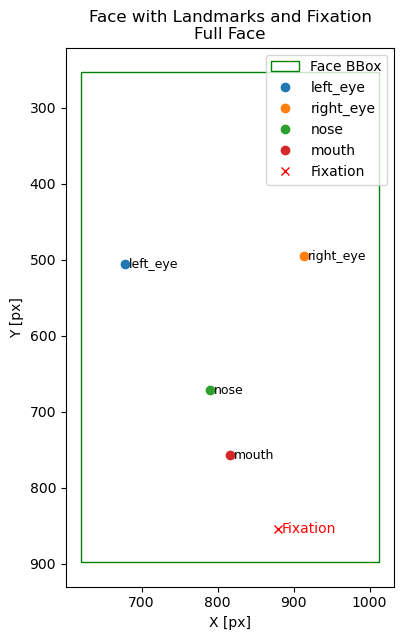

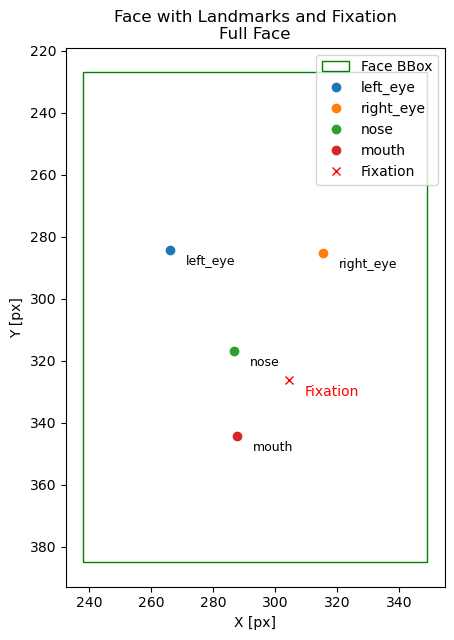

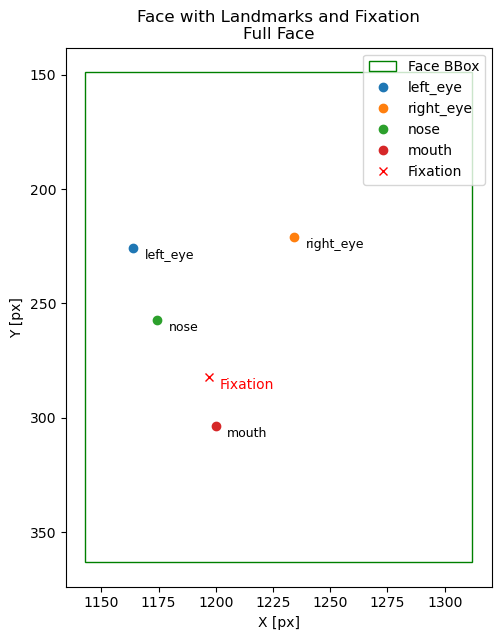

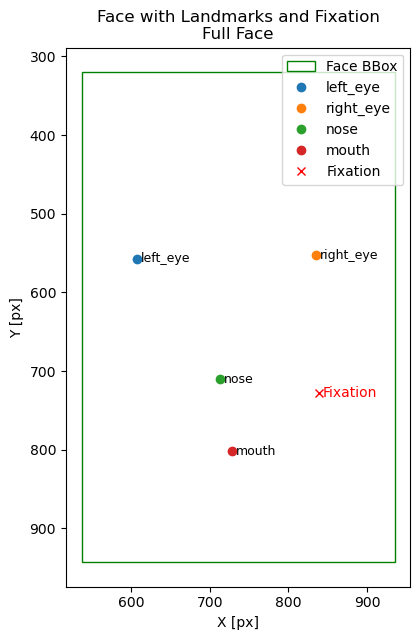

In [73]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_face_with_landmarks(fix_x, fix_y, aoi_centers, assigned_aoi, bbox, is_partial=None):
    fig, ax = plt.subplots(figsize=(7, 7))
    
    # Plot bounding box
    if bbox is not None:
        x1, y1, x2, y2 = bbox
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='g', facecolor='none', label='Face BBox')
        ax.add_patch(rect)
    
    # Plot AOI centers (landmarks)
    for aoi_id, (aoi_x, aoi_y) in aoi_centers.items():
        ax.plot(aoi_x, aoi_y, 'o', label=aoi_id)
        ax.text(aoi_x + 5, aoi_y + 5, aoi_id, fontsize=9, color='black')
    
    # Plot fixation point
    ax.plot(fix_x, fix_y, 'rx', label='Fixation')
    ax.text(fix_x + 5, fix_y + 5, 'Fixation', color='red')
    
    # Draw a line from fixation to the assigned AOI
    """if assigned_aoi in aoi_centers:
        aoi_x, aoi_y = aoi_centers[assigned_aoi]
        ax.plot([fix_x, aoi_x], [fix_y, aoi_y], 'r--', label='Assigned AOI link')"""

    if is_partial is not None:
        face_type = "Partial Face" if is_partial else "Full Face"
        ax.set_title(f'Face with Landmarks and Fixation\n{face_type}', fontsize=12)
    else:
        ax.set_title('Face with Landmarks and Fixation', fontsize=12)
    
    ax.set_xlabel('X [px]')
    ax.set_ylabel('Y [px]')
    ax.legend()
    ax.set_aspect('equal')
    plt.gca().invert_yaxis()  # Invert y-axis as working with screen coords
    plt.show()

# for each row in matched_df 
for _, row in full_faces_df.iterrows():
    mouth_x, mouth_y = mouth_centre(
        row['mouth left x [px]'], row['mouth left y [px]'],
        row['mouth right x [px]'], row['mouth right y [px]']
    )
    aoi_centers = {
        'left_eye': (row['eye left x [px]'], row['eye left y [px]']),
        'right_eye': (row['eye right x [px]'], row['eye right y [px]']),
        'nose': (row['nose x [px]'], row['nose y [px]']),
        'mouth': (mouth_x, mouth_y)
    }
    bbox = (row['p1 x [px]'], row['p1 y [px]'], row['p2 x [px]'], row['p2 y [px]'])
    plot_face_with_landmarks(
        fix_x=row['fixation x [px]'],
        fix_y=row['fixation y [px]'],
        aoi_centers=aoi_centers,
        assigned_aoi=row['assigned_aoi'],
        bbox=bbox,
        is_partial=row['partial_face']
    )


In [74]:
full_faces_df

,section id_x,recording id_x,fixation id_x,start timestamp [ns],end timestamp [ns]_x,duration [ms],fixation x [px],fixation y [px],azimuth [deg],elevation [deg],...,eye right x [px],eye right y [px],nose x [px],nose y [px],mouth left x [px],mouth left y [px],mouth right x [px],mouth right y [px],assigned_aoi,partial_face
0,993f45e1-9303-4f5b-9c0e-1fee427d17cd,0f400786-0ce5-43ca-984a-14062fc58ef7,236,1749034288728413116,1749034289043790116,315,863.616,189.259,2.922168,26.711734,...,845.281,125.542,815.690,146.997,805.936,177.528,845.420,172.548,mouth,False
1,993f45e1-9303-4f5b-9c0e-1fee427d17cd,0f400786-0ce5-43ca-984a-14062fc58ef7,237,1749034289063793116,1749034289839542116,776,871.944,191.226,3.494449,26.581656,...,888.846,130.943,861.243,154.943,851.024,185.889,891.346,180.433,mouth,False
2,993f45e1-9303-4f5b-9c0e-1fee427d17cd,0f400786-0ce5-43ca-984a-14062fc58ef7,245,1749034291260787116,1749034291405912116,145,1177.012,250.025,24.001883,22.200647,...,1223.607,190.133,1196.205,217.079,1150.946,223.811,1183.589,244.541,mouth,False
4,993f45e1-9303-4f5b-9c0e-1fee427d17cd,0f400786-0ce5-43ca-984a-14062fc58ef7,1044,1749034582712470116,1749034582867595116,155,597.746,496.373,-14.406244,7.017718,...,605.783,441.758,585.776,467.966,590.200,479.878,610.334,478.922,mouth,False
5,993f45e1-9303-4f5b-9c0e-1fee427d17cd,0f400786-0ce5-43ca-984a-14062fc58ef7,2045,1749034918940687116,1749034919090940116,150,935.469,485.086,7.372645,7.805539,...,947.715,493.729,939.259,502.175,932.164,507.579,943.854,508.902,left_eye,False
6,993f45e1-9303-4f5b-9c0e-1fee427d17cd,0f400786-0ce5-43ca-984a-14062fc58ef7,2163,1749034959528580116,1749034959758830116,230,875.304,493.729,3.484959,7.271140,...,910.165,629.670,783.919,806.451,696.908,883.650,887.553,881.201,right_eye,False
7,993f45e1-9303-4f5b-9c0e-1fee427d17cd,0f400786-0ce5-43ca-984a-14062fc58ef7,2164,1749034959943956116,1749034960054084116,110,850.561,929.861,1.961221,-20.707384,...,907.282,730.533,772.060,887.383,686.718,982.691,873.343,984.857,mouth,False
8,993f45e1-9303-4f5b-9c0e-1fee427d17cd,0f400786-0ce5-43ca-984a-14062fc58ef7,2165,1749034960094081116,1749034960179206116,85,876.200,857.877,3.616323,-16.095489,...,910.660,708.086,768.008,887.213,703.922,988.088,895.216,981.444,nose,False
9,993f45e1-9303-4f5b-9c0e-1fee427d17cd,0f400786-0ce5-43ca-984a-14062fc58ef7,2167,1749034960539456116,1749034960674581116,135,839.478,874.979,1.201249,-17.200036,...,878.585,722.246,738.078,896.908,656.959,1000.796,851.115,998.281,nose,False
10,993f45e1-9303-4f5b-9c0e-1fee427d17cd,0f400786-0ce5-43ca-984a-14062fc58ef7,2168,1749034960714706116,1749034960824831116,110,886.042,801.686,4.221424,-12.495040,...,888.432,685.930,748.083,863.293,681.526,962.394,865.948,951.409,right_eye,False


In [71]:
partial_faces_df

,section id_x,recording id_x,fixation id_x,start timestamp [ns],end timestamp [ns]_x,duration [ms],fixation x [px],fixation y [px],azimuth [deg],elevation [deg],...,eye right x [px],eye right y [px],nose x [px],nose y [px],mouth left x [px],mouth left y [px],mouth right x [px],mouth right y [px],assigned_aoi,partial_face
3,993f45e1-9303-4f5b-9c0e-1fee427d17cd,0f400786-0ce5-43ca-984a-14062fc58ef7,395,1749034341607772116,1749034341782894116,175,509.999,443.836,-20.146763,10.231051,...,548.347,443.763,547.267,462.779,530.079,470.699,530.996,471.885,mouth,True
13,993f45e1-9303-4f5b-9c0e-1fee427d17cd,0f400786-0ce5-43ca-984a-14062fc58ef7,2435,1749035060312486116,1749035060467611116,155,274.281,458.540,-35.321786,8.903924,...,311.518,395.786,323.265,412.608,300.901,434.891,308.701,435.158,mouth,True
16,993f45e1-9303-4f5b-9c0e-1fee427d17cd,0f400786-0ce5-43ca-984a-14062fc58ef7,4062,1749035656247815116,1749035656322825116,75,1071.204,370.658,16.377705,14.932230,...,1054.469,313.135,1045.325,348.338,1068.536,368.926,1068.455,367.507,mouth,True
20,993f45e1-9303-4f5b-9c0e-1fee427d17cd,0f400786-0ce5-43ca-984a-14062fc58ef7,4214,1749035720137322116,1749035720307447116,170,739.030,153.630,-5.758767,28.948203,...,665.850,7.057,627.530,64.415,662.689,123.075,666.644,124.426,mouth,True
22,993f45e1-9303-4f5b-9c0e-1fee427d17cd,0f400786-0ce5-43ca-984a-14062fc58ef7,4217,1749035721153197116,1749035721398447116,245,882.894,178.827,4.270175,27.363913,...,906.318,2.208,845.149,78.213,894.688,159.154,946.029,114.719,mouth,True


#### To check if unmatched fixations fall into a bounding box ####

In [11]:
### if i want to illustrate all

"""for _, row in matched_df.iterrows():
    ts_start = row['start timestamp [ns]']
    ts_end = row['end timestamp [ns]_x']
    fx, fy = row['fixation x [px]'], row['fixation y [px]']

    candidates = face_detections_df[
        (face_detections_df['timestamp [ns]'] >= ts_start) &
        (face_detections_df['timestamp [ns]'] <= ts_end)
    ]

    plt.figure(figsize=(8, 6))
    for _, det in candidates.iterrows():
        x1, y1 = det['p1 x [px]'], det['p1 y [px]']
        x2, y2 = det['p2 x [px]'], det['p2 y [px]']
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='blue'))
    plt.plot(fx, fy, 'ro')  # fixation point
    plt.title(f"Fixation at timestamp: {ts_start}–{ts_end}")
    plt.gca().invert_yaxis()
    plt.show()"""


'for _, row in matched_df.iterrows():\n    ts_start = row[\'start timestamp [ns]\']\n    ts_end = row[\'end timestamp [ns]_x\']\n    fx, fy = row[\'fixation x [px]\'], row[\'fixation y [px]\']\n\n    candidates = face_detections_df[\n        (face_detections_df[\'timestamp [ns]\'] >= ts_start) &\n        (face_detections_df[\'timestamp [ns]\'] <= ts_end)\n    ]\n\n    plt.figure(figsize=(8, 6))\n    for _, det in candidates.iterrows():\n        x1, y1 = det[\'p1 x [px]\'], det[\'p1 y [px]\']\n        x2, y2 = det[\'p2 x [px]\'], det[\'p2 y [px]\']\n        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=\'blue\'))\n    plt.plot(fx, fy, \'ro\')  # fixation point\n    plt.title(f"Fixation at timestamp: {ts_start}–{ts_end}")\n    plt.gca().invert_yaxis()\n    plt.show()'

In [ ]:
# Get unmatched fixation IDs
all_fixation_ids = set(face_with_coordinates_df['fixation id_x'])
matched_fixation_ids = set(matched_df['fixation id_x'])

unmatched_ids = list(all_fixation_ids - matched_fixation_ids)
print(f"Fixation IDs unmatched: {len(unmatched_ids)}")

# For each unmatched fixation, check whether the fixation falls inside any face bbox during its interval
check_results = []

for fid in unmatched_ids:
    fixation_row = face_with_coordinates_df[face_with_coordinates_df['fixation id_x'] == fid].iloc[0]

    ts_start = fixation_row['start timestamp [ns]']
    ts_end = fixation_row['end timestamp [ns]_x']
    fx = fixation_row['fixation x [px]']
    fy = fixation_row['fixation y [px]']

    detections = face_detections_df[
        (face_detections_df['timestamp [ns]'] >= ts_start) &
        (face_detections_df['timestamp [ns]'] <= ts_end)
    ]

    matched = False
    for _, det in detections.iterrows():
        x1, y1 = det['p1 x [px]'], det['p1 y [px]']
        x2, y2 = det['p2 x [px]'], det['p2 y [px]']

        # Ensure proper box orientation
        x1, x2 = min(x1, x2), max(x1, x2)
        y1, y2 = min(y1, y2), max(y1, y2)

        if x1 <= fx <= x2 and y1 <= fy <= y2:
            matched = True
            break

    check_results.append({
        'fixation id': fid,
        'start timestamp [ns]': ts_start,
        'end timestamp [ns]_x': ts_end,
        'fixation x [px]': fx,
        'fixation y [px]': fy,
        'falls_in_any_bbox': matched
    })

#  Create a summary DataFrame
unmatched_check_df = pd.DataFrame(check_results)
print(unmatched_check_df['falls_in_any_bbox'].value_counts())


Fixation IDs unmatched: 13
falls_in_any_bbox
False    13
Name: count, dtype: int64


In [ ]:
## to get a list of all unmatched fixations from the recording with their ts and ids
unmatched_check_df
#unmatched_check_df.to_csv('unmatched_fixation_bbox_check.csv', index=False)

,fixation id,start timestamp [ns],end timestamp [ns]_x,fixation x [px],fixation y [px],falls_in_any_bbox
0,3009,1743587311832408504,1743587312117658504,859.275,1079.457,False
1,6275,1743588562015043504,1743588562170170504,1278.684,373.863,False
2,3398,1743587478447438504,1743587478522560504,940.695,319.634,False
3,2599,1743587155491841504,1743587155812091504,489.665,461.972,False
4,5386,1743588238875379504,1743588239045507504,808.915,300.881,False
5,4941,1743588054839060504,1743588057481440504,794.566,1041.821,False
6,4142,1743587742508304504,1743587742658429504,871.323,420.498,False
7,5391,1743588240516885504,1743588241092381504,718.997,310.658,False
8,2926,1743587277060009504,1743587277605509504,1115.779,922.562,False
9,5298,1743588209357864504,1743588209773230504,822.512,300.530,False


In [14]:
## to ilustrate unmatched ones

"""#  Iterate through the unmatched fixations
for _, row in unmatched_check_df.iterrows():
    if row['falls_in_any_bbox'] == False:  # Only show unmatched fixations
        ts_start = row['start timestamp [ns]']
        ts_end = row['end timestamp [ns]_x']
        fx, fy = row['fixation x [px]'], row['fixation y [px]']

        # Get all face detections within this timestamp range
        candidates = face_detections_df[
            (face_detections_df['timestamp [ns]'] >= ts_start) &
            (face_detections_df['timestamp [ns]'] <= ts_end)
        ]

       # Create a plot for each unmatched fixation
        plt.figure(figsize=(8, 6))
        for _, det in candidates.iterrows():
            x1, y1 = det['p1 x [px]'], det['p1 y [px]']
            x2, y2 = det['p2 x [px]'], det['p2 y [px]']
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='blue'))

        # Plot the fixation point (red dot)
        plt.plot(fx, fy, 'ro', label="Fixation")

        # Add title, invert y-axis for proper coordinate display
        plt.title(f"Unmatched Fixation\nTime: {ts_start}–{ts_end}")
        plt.gca().invert_yaxis()  # Invert Y-axis for image coordinates
        plt.legend()
        plt.show()
"""

'#  Iterate through the unmatched fixations\nfor _, row in unmatched_check_df.iterrows():\n    if row[\'falls_in_any_bbox\'] == False:  # Only show unmatched fixations\n        ts_start = row[\'start timestamp [ns]\']\n        ts_end = row[\'end timestamp [ns]_x\']\n        fx, fy = row[\'fixation x [px]\'], row[\'fixation y [px]\']\n\n        # Get all face detections within this timestamp range\n        candidates = face_detections_df[\n            (face_detections_df[\'timestamp [ns]\'] >= ts_start) &\n            (face_detections_df[\'timestamp [ns]\'] <= ts_end)\n        ]\n\n       # Create a plot for each unmatched fixation\n        plt.figure(figsize=(8, 6))\n        for _, det in candidates.iterrows():\n            x1, y1 = det[\'p1 x [px]\'], det[\'p1 y [px]\']\n            x2, y2 = det[\'p2 x [px]\'], det[\'p2 y [px]\']\n            plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=\'blue\'))\n\n        # Plot the fixation point (red dot)\n 